# Implementation of the dMMSB model (dynamic)

In [ ]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
from jax.scipy.special import logsumexp
from jax.nn import softmax

from jax import vmap, jit
from jax.tree_util import register_pytree_node_class
from functools import partial

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

from utils.plots import plot_roles
from utils.utils import compute_best_permutation, l1_loss

from models.dMMSB import jitdMMSB



In [2]:
#attempt to fix
class dMMSB():
    def __init__(self, nodes, roles, timesteps, **kwargs):
        self.N = nodes
        self.K = roles
        self.T = timesteps

        self.key = kwargs.get('key', jax.random.PRNGKey(0))
        self.B = kwargs.get('B', None)
        self.mu = kwargs.get('mu', None)
        self.Sigma = kwargs.get('Sigma', None)
        self.gamma_tilde = kwargs.get('gamma_tilde', None)
        self.Sigma_tilde = kwargs.get('Sigma_tilde', None)
        self.nu = kwargs.get('nu', None)
        self.Phi = kwargs.get('Phi', None)

        # Initialize model parameters 
        if self.B is None:
            self.B = jax.random.uniform(self.key, (self.K, self.K)) #shape (K,K)
        if self.nu is None:
            self.nu = jax.random.normal(self.key) # scalar
        if self.mu is None:
            self.mu = jnp.tile(jnp.zeros(self.K - 1)[None, :], (self.T, 1)) + self.nu  #shape (T, K-1)
        if self.Phi is None:
            self.Phi = jnp.eye(self.K - 1) * 20 #shape (K-1, K-1)
        if self.Sigma is None:
            self.Sigma = jnp.tile(jnp.eye(self.K - 1)[None, :, :], (self.T, 1, 1)) * 10 #shape (T, K-1, K-1)

        # Changed: P is now (T, K-1, K-1) instead of (T, K, K)
        #KF RTS variables
        self.P = jnp.tile(jnp.eye(self.K - 1)[None, :, :], (self.T, 1, 1)) * 20 #shape (T, K-1, K-1) | NOTE: large initial covariance
        self.Y = None
        self.L = None

        self.EPS = 1e-10

    def expand_gamma(self, gamma_km1):
        '''
        Help function to expand gamma from K-1 to K by appending zeros
        gamma_km1: (..., K-1) 
        returns: (..., K)
        '''
        assert gamma_km1.shape[-1] == self.K - 1, f"Input gamma must have last dimension K-1={self.K-1}"
        zeros = jnp.zeros(gamma_km1.shape[:-1] + (1,))
        return jnp.concatenate([gamma_km1, zeros], axis=-1)
        
    def log_likelihood(self, delta, B, E):
        '''
        Compute the log likelihood of the data given the current parameters. eq (25)
        delta: shape (T,N,N,K,K)
        B: shape (K,K)
        E: shape (T,N,N)
        '''
        E_reshaped = E[:, :, :, None, None] # shape (T,N,N,1,1)
        B_reshaped = B[None, None, None, :, :] # shape (1,1,1,K,K)
        logB = jnp.log(B_reshaped + self.EPS) # shape (1,1,1,K,K)
        log1mB = jnp.log(1.0 - B_reshaped + self.EPS) # shape (1,1,1,K,K)

        ll_matrix = delta * (E_reshaped * logB + (1.0 - E_reshaped) * log1mB) # shape (T,N,N,K,K)
        ll = jnp.sum(ll_matrix)
        return ll
    
    #--------------------------------------------------------------
    # Inner Loop functions (From static version)
    #--------------------------------------------------------------

    def _compute_deltas(self, gamma_tilde, E):
        '''
        Compute delta matrices for all pairs (i,j) given current gamma_tilde and B
        gamma_tilde: (N,K) - NOTE: This should be K-dimensional (expanded)
        E: adjacency matrix (N,N)
        Returns: delta (N,N,K,K)
        '''
        assert gamma_tilde.shape[1] == self.K, "gamma_tilde must have shape (N, K) for delta computation"
        
        gamma_i = gamma_tilde[:, None, :, None] # shape (N,1,K,1)
        gamma_j = gamma_tilde[None, :, None, :] # shape (1,N,1,K)

        gamma_sum = gamma_i + gamma_j # shape (N,N,K,K)

        B_reshaped = self.B[None, None, :, :] # shape (1,1,K,K)
        E_reshaped = E[:, :, None, None] # shape (N,N,1,1)

        log_bernoulli = jnp.where(E_reshaped == 1,
                                jnp.log(B_reshaped + self.EPS),
                                jnp.log1p(-B_reshaped + self.EPS))  # log(1-B) more stable

        delta_exp_term = gamma_sum + log_bernoulli # shape (N,N,K,K)
        max_delta_exp = jnp.max(delta_exp_term, axis=(-1,-2), keepdims=True)
        delta = jnp.exp(delta_exp_term - (max_delta_exp + logsumexp(delta_exp_term - max_delta_exp, axis=(-1,-2), keepdims=True))) # shape (N,N,K,K) logsumexp trick for numerical stability
        return delta # shape (N,N,K,K)
    
    def _compute_g_H(self, gamma_hat):
        '''
        Compute g and H at gamma_hat
        gamma_hat: (N, K)
        Returns: g: (N, K), H: (N, K, K)
        '''
        assert gamma_hat.shape[1] == self.K, "gamma_hat must have shape (N, K)"
        
        max_gamma = jnp.max(gamma_hat, axis=-1, keepdims=True)
        g = jnp.exp(gamma_hat - (max_gamma + logsumexp(gamma_hat - max_gamma, axis=-1, keepdims=True))) # shape (N,K)
        H = jnp.einsum('ni,ij->nij', g, jnp.eye(self.K)) - jnp.einsum('ni,nj->nij', g, g) # shape (N,K,K)
        
        return g, H

    def _update_sigma_tilde(self, Sigma_inv, H):
        '''
        Compute Sigma_tilde = (Sigma^{-1} + (2N-2) H_{1:K-1, 1:K-1})^{-1}
        Sigma_inv: (K-1, K-1)
        H: (N, K, K) Hessian from the K-dimensional expansion
        Returns: Sigma_tilde: (N, K-1, K-1)
        '''
        # Take the top-left (K-1, K-1) block of the Hessian
        H_km1 = H[:, :self.K - 1, :self.K - 1] # shape (N, K-1, K-1)
        
        factor = 2.0 * self.N - 2.0
        A = Sigma_inv[None, :, :] + factor * H_km1
        jitter = 1e-5 * jnp.eye(self.K - 1) # for numerical stability
        A = A + jitter[None, :, :]
        Sigma_tilde = jnp.linalg.inv(A)
        return Sigma_tilde

    def _compute_m_expect(self, delta):
        '''
        Compute m_expect per node: m_i,k = sum_{j != i} (E[z_i->j,k] + E[z_i<-j,k])
        delta: (N,N,K,K)
        Returns: m_expect: (N,K)
        '''
        z_ij = jnp.sum(delta, axis=-1) # shape (N,N,K) Expected z_i->j (sender)
        z_ji = jnp.sum(delta, axis=-2) # shape (N,N,K) Expected z_i<-j (receiver)

        z_ij_expected = jnp.sum(z_ij, axis=1) # shape (N,K)
        z_ji_expected = jnp.sum(z_ji, axis=0) # shape (N,K)

        z_sum = z_ij_expected + z_ji_expected# shape (N,K)

        diag_ij = jnp.diagonal(z_ij, axis1=0, axis2=1).T # shape(N,K)
        diag_ji = jnp.diagonal(z_ji, axis1=0, axis2=1).T # shape(N,K)
    
        m_expect = z_sum - diag_ij - diag_ji # shape (N,K)

        return m_expect # shape (N,K)
   
    def _update_gamma_tilde(self, delta, mu, Sigma_tilde, gamma_hat, g, H):
        '''
        Update gamma_tilde using Laplace approximation
        delta: (N,N,K,K)
        mu: (K-1,)
        Sigma_tilde: (N,K-1,K-1)
        gamma_hat: (N,K)
        g: (N,K)
        H: (N,K,K)
        Returns: gamma_tilde: (N,K-1)
        '''
        factor = 2.0 * self.N - 2.0

        # m_expect is computed over all K roles and must not be truncated.
        m_expect = self._compute_m_expect(delta) # shape (N, K)
        
        # Expand mu to K dimensions for the calculation
        mu_expanded = jnp.append(mu, 0.0) # shape (K,)
        
        # The term in brackets from the paper's appendix is K-dimensional
        # It uses all K-dimensional components: m_expect, g, H, gamma_hat, mu_expanded
        term_1_full = (m_expect - factor * g + 
                    factor * jnp.einsum('nij,nj->ni', H, gamma_hat) - 
                    factor * jnp.einsum('nij,j->ni', H, mu_expanded)) # shape (N, K)

        # Truncate the update vector to K-1 dimensions right before the final multiplication
        term_1_km1 = term_1_full[:, :self.K - 1] # shape (N, K-1)

        # Final update is in K-1 dimensional space
        gamma_tilde = mu[None, :] + jnp.einsum('nij,nj->ni', Sigma_tilde, term_1_km1) # shape (N, K-1)

        return gamma_tilde # shape (N, K-1)

    def inner_step_static(self, gamma_tilde, Sigma_tilde, mu, Sigma_inv, E):
        '''
        Perform one inner iteration to update gamma_tilde and Sigma_tilde
        gamma_tilde: (N,K-1)
        Sigma_tilde: (N,K-1,K-1)
        mu: (K-1,)
        Sigma_inv: (K-1,K-1)
        E: adjacency matrix (N,N)
        Returns: updated gamma_tilde (N,K-1), Sigma_tilde (N,K-1,K-1), delta (N,N,K,K)
        '''
        # Expand gamma_tilde to K dimensions for delta computation
        gamma_hat = self.expand_gamma(gamma_tilde) # shape (N, K)
    
        delta = self._compute_deltas(gamma_hat, E) # shape (N,N,K,K)
        g, H = self._compute_g_H(gamma_hat) # g: (N,K), H: (N,K,K)
        Sigma_tilde = self._update_sigma_tilde(Sigma_inv, H) # shape (N,K-1,K-1)
        gamma_tilde = self._update_gamma_tilde(delta, mu, Sigma_tilde, gamma_hat, g, H) # shape (N,K-1)
        return gamma_tilde, Sigma_tilde, delta

    #--------------------------------------------------------------
    
    def inner_step(self, gamma_tilde, Sigma_tilde, mu, Sigma_inv, E):
        '''
        Perform one inner iteration to update gamma_tilde and Sigma_tilde for all time steps using vmap
        gamma_tilde: (T,N,K-1)
        Sigma_tilde: (T,N,K-1,K-1)
        mu: (T,K-1)
        Sigma_inv: (T,K-1,K-1)
        E: adjacency matrix (T,N,N)
        Returns: updated 
        gamma_tilde (T,N,K-1)
        Sigma_tilde (T,N,K-1,K-1)
        delta (T,N,N,K,K)
        '''

        gamma_tilde, Sigma_tilde, delta = vmap(self.inner_step_static, in_axes=(0,0,0,0,0))(gamma_tilde, Sigma_tilde, mu, Sigma_inv, E)
        return gamma_tilde, Sigma_tilde, delta

    def update_mu(self, mu, P, Y, Sigma, Phi, N):
        '''
        Update mu using Kalman filter and RTS smoother with jax.lax.scan. eq (14,15,16,17)
        mu: shape (T,K-1) 
        P: shape (T,K-1,K-1)
        Y: shape (T,K-1)
        Sigma: shape (T,K-1,K-1) 
        Phi: shape (K-1,K-1) 
        N: scalar, number of nodes
        '''
        T = mu.shape[0]

        # --- 1. Kalman Filter (Forward Pass) ---
        def kalman_step(carry, inputs):
            mu_prev, P_prev = carry
            Y_t, Sigma_t = inputs

            # Prediction step
            mu_pred_t = mu_prev
            P_pred_t = P_prev + Phi

            # Update step
            tmp = P_pred_t + Sigma_t/N
            K_t = jnp.linalg.solve(tmp.T, P_pred_t.T).T  #numerically stable version
            mu_t = mu_pred_t + K_t @ (Y_t - mu_pred_t)
            P_t = P_pred_t - K_t @ P_pred_t

            new_carry = (mu_t, P_t)
            # Stack filtered and predicted states for the backward pass
            outputs_to_stack = (mu_t, P_t, mu_pred_t, P_pred_t)
            return new_carry, outputs_to_stack

        init_carry = (mu[0], P[0])
        inputs = (Y[1:], Sigma[1:])
        _, (mu_filtered_scanned, P_filtered_scanned, mu_pred_scanned, P_pred_scanned) = jax.lax.scan(
            kalman_step, init_carry, inputs, unroll=True
        )

        # Combine initial state with scanned results
        mu_filtered = jnp.concatenate([mu[0][None, :], mu_filtered_scanned], axis=0)
        P_filtered = jnp.concatenate([P[0][None, :, :], P_filtered_scanned], axis=0)
        # The prediction for time t is mu_{t-1}, so mu_pred starts from mu_0
        mu_pred = jnp.concatenate([mu[0][None, :], mu_pred_scanned], axis=0)
        P_pred = jnp.concatenate([P[0][None, :, :], P_pred_scanned], axis=0)

        # --- 2. RTS Smoother (Backward Pass) ---
        def rts_smoother_step(carry, inputs):
            mu_smooth_next, P_smooth_next = carry
            mu_filtered_t, P_filtered_t, mu_pred_next, P_pred_next = inputs

            L_t = jnp.linalg.solve(P_pred_next.T, P_filtered_t.T).T  # numerically stable version
            
            # Update step
            mu_smooth_t = mu_filtered_t + L_t @ (mu_smooth_next - mu_pred_next)
            P_smooth_t = P_filtered_t + L_t @ (P_smooth_next - P_pred_next) @ L_t.T

            new_carry = (mu_smooth_t, P_smooth_t)
            outputs_to_stack = (mu_smooth_t, P_smooth_t, L_t)
            return new_carry, outputs_to_stack

        init_carry_smooth = (mu_filtered[-1], P_filtered[-1])
        inputs_smooth = (mu_filtered[:-1], P_filtered[:-1], mu_pred[1:], P_pred[1:])
        
        _, (mu_smooth_scanned, P_smooth_scanned, L_scanned) = jax.lax.scan(
            rts_smoother_step, init_carry_smooth, inputs_smooth, reverse=True, unroll=True
        )

        mu_smooth = jnp.concatenate([mu_smooth_scanned, mu_filtered[-1][None, :]], axis=0)
        P_smooth = jnp.concatenate([P_smooth_scanned, P_filtered[-1][None, :, :]], axis=0)
        L = jnp.concatenate([L_scanned, jnp.zeros((1, P.shape[1], P.shape[2]))], axis=0)  # Last L is not defined

        return mu_smooth, P_smooth, L 

    def update_B(self, delta, E):
        '''
        Update B using the current parameters. eq (26)
        delta: shape (T,N,N,K,K)
        E: shape (T,N,N)
        '''
        E_reshaped = E[:, :, :, None, None] # shape (T,N,N,1,1)
        
        num = jnp.sum(delta * E_reshaped, axis=(0,1,2)) # shape (K,K)
        den = jnp.sum(delta, axis=(0,1,2)) # shape (K,K)

        B_new = jnp.where(den < self.EPS, 
                  0.5 * jnp.ones_like(num),  
                  num / jnp.maximum(den, self.EPS)) # shape (K,K)
        B_new = jnp.clip(B_new, 1e-6, 1 - 1e-6)

        return B_new
    
    def update_Phi(self, mu, P, L):
        """
        Vectorized update of Phi using eq (19).
        mu: shape (T, K-1)
        P: shape (T, K-1, K-1)
        L: shape (T, K-1, K-1)
        """
        diffs = mu[1:] - mu[:-1]  

        term1 = jnp.einsum("ti,tj->tij", diffs, diffs) # shape (T-1, K-1, K-1)
        term2 = jnp.einsum("tik,tkl,tjl->tij", L[:-1], P[1:], L[:-1]) # shape (T-1, K-1, K-1)

        Phi_new = (term1 + term2).mean(axis=0)
        # Ensure positive definiteness
        Phi_new = Phi_new + jnp.eye(self.K - 1) * self.EPS  
        return Phi_new

    def update_Sigma(self, mu, gamma_tilde, Sigma_tilde, N):
        '''
        Update Sigma_tilde using the current parameters. eq (20)
        mu: shape (T,K-1)
        gamma_tilde: shape (T,N,K-1)
        Sigma_tilde: shape (T,N,K-1,K-1)
        N: scalar, number of nodes
        '''
        
        diff = mu[:, None, :] - gamma_tilde # shape (T,N,K-1)
        
        sum_outer_products = jnp.einsum('tnk,tnj->tkj', diff, diff)  # shape (T,K-1,K-1) 

        sum_Sigma_tilde = jnp.sum(Sigma_tilde, axis=1)  # shape (T,K-1,K-1)

        Sigma_new = (sum_outer_products + sum_Sigma_tilde) / N  # shape (T,K-1,K-1)
    

        if (not jnp.allclose(Sigma_new, jnp.transpose(Sigma_new, (0,2,1)), atol=1e-6)):
            print("Warning: Sigma_new is not symmetric!")

        Sigma_new = Sigma_new + jnp.eye(self.K - 1)[None, :, :] * 1e-5 # Ensure positive definiteness
        return Sigma_new
    
    def update_nu(self, mu):
        '''
        Update nu using the current parameters. eq (21)
        mu: shape (T,K-1)
        '''
        return mu[0]  # Return first time step mu (still K-1 dimensional)
    
    def fit(self, E, max_inner_iters=100, max_outer_iters=100, tol=1e-6, verbose=False):
        '''
        Fit the model to adjacency matrix E using variational EM
        Algorithm described in section 4.2 of the paper
        
        E: adjacency matrix (T,N,N)
        max_inner_iters: maximum iterations for inner loop
        max_outer_iters: maximum iterations for outer loop
        tol: tolerance for convergence
        verbose: whether to print progress
        '''
        
        i = 0 
        d_ll = jnp.inf
        prev_outer_ll = -jnp.inf
        while(d_ll > tol and i < max_outer_iters): # 2 (outer loop)
            if verbose:
                print(f"[outer {i}] mu: {self.mu}, Sigma diag: {jnp.diagonal(self.Sigma, axis1=1, axis2=2)}, B: {self.B}")

            #initialize q(gamma) parameters
            def init_q_gamma(key, mu_t, Sigma_t, N, K):
                '''
                Initialize q(gamma) and Sigma^-1 for a single time step.
                mu_t: (K-1,)
                Sigma_t: (K-1,K-1)
                Returns: gamma_tilde (N,K-1), Sigma_tilde (N,K-1,K-1), Sigma_inv (K-1,K-1)
                '''
                key, subkey = jax.random.split(key)
                gamma_tilde = jax.random.multivariate_normal(subkey, mu_t, Sigma_t, shape=(N,)) # shape (N,K-1)
                gamma_tilde = jnp.clip(gamma_tilde, -10, 10)  # gradient clipping
                # Expand for g,H computation
                gamma_hat = self.expand_gamma(gamma_tilde) # shape (N, K)
                g, H = self._compute_g_H(gamma_hat) # g: (N,K), H: (N,K,K)

                jitter = 1e-5 * jnp.eye(K - 1) # for numerical stability
                Sigma_inv = jnp.linalg.inv(Sigma_t + jitter) # shape (K-1,K-1)
                Sigma_tilde = self._update_sigma_tilde(Sigma_inv, H) # shape (N,K-1,K-1)

                return gamma_tilde, Sigma_tilde, Sigma_inv

            self.gamma_tilde, self.Sigma_tilde, Sigma_inv = vmap(init_q_gamma, in_axes=(None, 0, 0, None, None))(self.key, self.mu, self.Sigma, self.N, self.K) # shape (T,N,K-1), (T,N,K-1,K-1), (T,K-1,K-1)

            #NOTE:add multiple runs with different initializaitons and use of VMAP
            j = 0
            inner_d_ll = jnp.inf
            prev_inner_ll = -jnp.inf
            while(inner_d_ll > tol and j < max_inner_iters): # 2.2 inner loop
                #2.2.1 update q(gamma) and q(z) 
                self.gamma_tilde, self.Sigma_tilde, self.delta = self.inner_step(self.gamma_tilde, self.Sigma_tilde, self.mu, Sigma_inv, E)

                # 2.2.2 update B
                self.B = self.update_B(self.delta, E) # shape (K,K)

                #convergence check
                j += 1
                inner_ll = self.log_likelihood(self.delta, self.B, E) 
                inner_d_ll = jnp.abs(inner_ll - prev_inner_ll)
                prev_inner_ll = inner_ll

                if verbose:
                    print(f"  [inner {j}] ll: {inner_ll:.4f}, d_ll: {inner_d_ll:.6f}")

            # 2.3 RTS smoother to update mu and P
            self.Y = jnp.mean(self.gamma_tilde, axis=1) # shape (T,K-1)
            self.mu, self.P, self.L = self.update_mu(self.mu, self.P, self.Y, self.Sigma, self.Phi, self.N)

            # 2.4 update nu, Phi, Sigma
            self.nu = self.update_nu(self.mu) # Now (K-1,) dimensional
            self.Phi = self.update_Phi(self.mu, self.P, self.L) # shape (K-1,K-1)
            self.Sigma = self.update_Sigma(self.mu, self.gamma_tilde, self.Sigma_tilde, self.N) # shape (T,K-1,K-1)

            #convergence check
            i += 1
            outer_ll = inner_ll #last inner ll is outer ll
            d_ll = jnp.abs(outer_ll - prev_outer_ll)
            prev_outer_ll = outer_ll

        return outer_ll
    
    def generate_graph(self):
        '''
        Generate a graph from the model
        Returns: adjacency matrix E (T,N,N)
        '''
        if self.B is None:
            raise ValueError("Must initialize B before generating a graph.")

        key = self.key
        if self.gamma_tilde is None:
            if self.nu is None or self.Phi is None or self.Sigma is None:
                raise ValueError("Must initialize nu, Phi, and Sigma before generating a graph if gamma_tilde is not set.")
            
            key, subkey = jax.random.split(key)
            mu_0 = jax.random.multivariate_normal(subkey, self.nu, self.Phi)

            def sample_mu_step(carry, key_t):
                mu_prev = carry
                mu_t = jax.random.multivariate_normal(key_t, mu_prev, self.Phi)
                return mu_t, mu_t

            keys = jax.random.split(key, self.T - 1)
            _, mu_rest = jax.lax.scan(sample_mu_step, mu_0, keys)
            self.mu = jnp.concatenate([mu_0[None, :], mu_rest], axis=0)
            
            def sample_gamma_t(key_t, mu_t, Sigma_t):
                return jax.random.multivariate_normal(key_t, mu_t, Sigma_t, shape=(self.N,))

            key, subkey = jax.random.split(key)
            keys = jax.random.split(subkey, self.T)
            self.gamma_tilde = vmap(sample_gamma_t)(keys, self.mu, self.Sigma)
        
        gamma_expanded = vmap(self.expand_gamma)(self.gamma_tilde) # shape (T,N,K)
        pis = softmax(gamma_expanded, axis=-1) # shape (T,N,K)

        def sample_E(key, pis_t):
            key, subkey1, subkey2, subkey3 = jax.random.split(key, 4)
            z_ij = jax.random.multinomial(subkey1, 1, pis_t, shape=(self.N, self.N, self.K)) # shape (N,N,K)
            z_ji = jax.random.multinomial(subkey2, 1, pis_t, shape=(self.N, self.N, self.K)) # shape (N,N,K)

            p = jnp.einsum('ijk, kl -> ijl', z_ij, self.B) # shape (N,N,K)
            p = jnp.einsum('ijl, jil -> ij', p, z_ji) # shape (N,N)
            E_t = jax.random.bernoulli(subkey3, p=p)
            return E_t
    
        E = vmap(sample_E, in_axes=(0,0))(jax.random.split(key, self.T), pis) # shape (T,N,N)
        return E.astype(jnp.int32) # shape (T,N,N)

# Generation and Inference

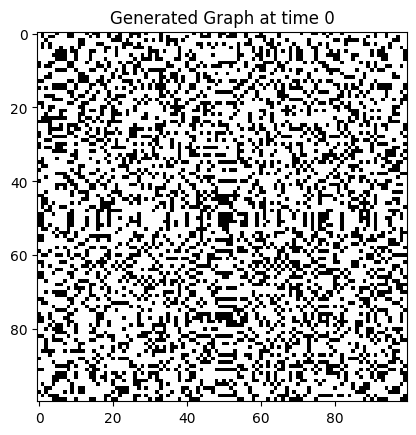

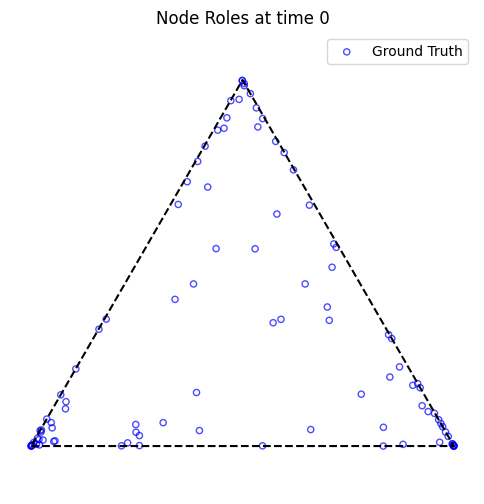

Mu at time 0: [-0.21089035 -1.28566   ]


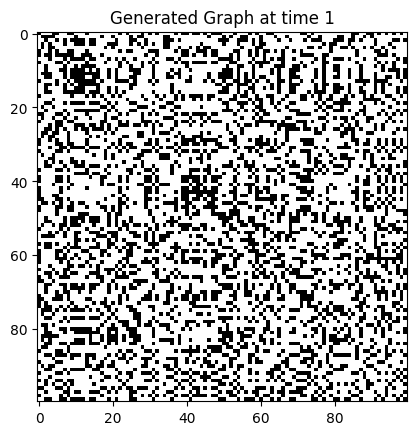

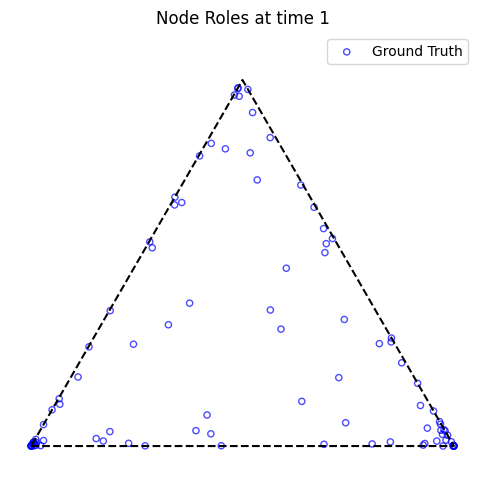

Mu at time 1: [ 1.3723841 -0.4343449]


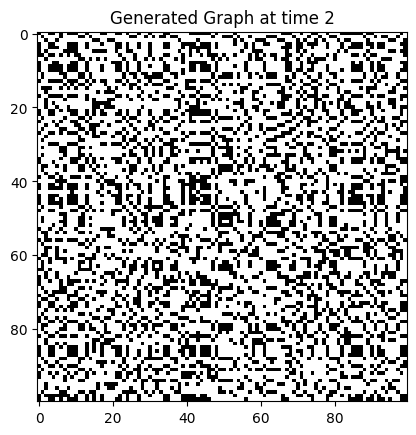

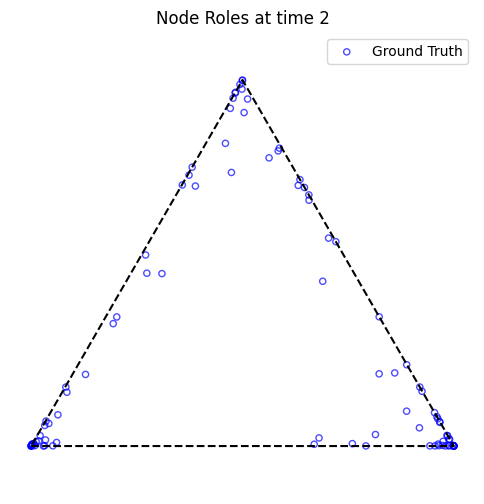

Mu at time 2: [ 0.9774859 -1.0006907]


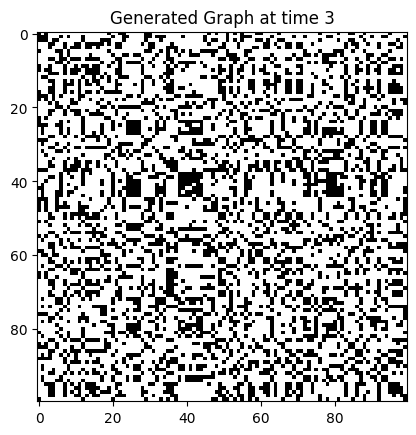

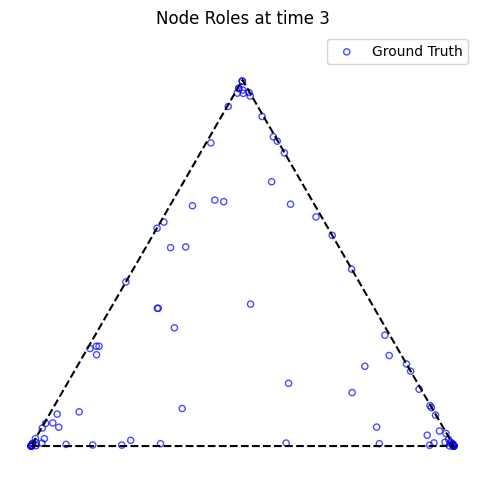

Mu at time 3: [ 1.2581482 -0.4722973]


In [3]:
nu =  jnp.array([0,0]) # Use K-1 dimension
#mu = jnp.tile(mu_0[None, :], (4, 1)) # Create a (T, K-1) array
Phi = jnp.array([[1,.5],
                 [.5,1]], dtype=jnp.float32) * 1
Sigma = jnp.tile(jnp.eye(2)[None, :, :], (4, 1, 1)) * 20 # Use K-1 dimension and T=4
B = jnp.array([[1,0,0],
               [0,1,0],
               [0,0,1]], dtype=jnp.float32) 



gen_model = jitdMMSB(nodes=100, roles=3, timesteps=4, key=jax.random.PRNGKey(42), Sigma=Sigma, B=B, Phi=Phi, nu=nu)
E_sample = gen_model.generate_graph()


for t in range(E_sample.shape[0]):
    plt.imshow(E_sample[t], cmap='Greys', vmin=0, vmax=1)
    plt.title(f"Generated Graph at time {t}")
    plt.show()
    expanded_gamma = jnp.concatenate([gen_model.gamma_tilde[t], jnp.zeros((gen_model.N, 1))], axis=-1) # shape (T,N,K)
    pis = softmax(expanded_gamma, axis=-1)
    plot_roles(pis, title=f"Node Roles at time {t}")
    print(f"Mu at time {t}: {gen_model.mu[t]}")

In [4]:
best_model = None
best_jit_ll = -jnp.inf
for run in range(5):
    print(f"Run {run+1}")

    jit_model = jitdMMSB(nodes=100, roles=3, timesteps=4, key=jax.random.PRNGKey(10+run))
    ll = jit_model.fit(E_sample, max_inner_iters=1000, max_outer_iters=50, tol=1e-6, verbose=True)

    if ll > best_jit_ll:
        best_jit_ll = ll
        best_model = jit_model
    print(f"Jitted | Current ll:{ll} | Best ll:{best_jit_ll}")

    # print("B learned:\n", jit_model.B)
    # print("Phi learned:\n", jit_model.Phi)
    # print("Sigma learned:\n", jit_model.Sigma)

    # model = dMMSB(nodes=100, roles=3, timesteps=4, key=jax.random.PRNGKey(run+10))
    # ll = model.fit(E_sample, max_inner_iters=500, max_outer_iters=50, tol=1e-4, verbose=True)
    # if ll > best_ll:
    #     best_ll = ll
    #     best_model = model
    # print(f"Current ll:{ll} | Best ll:{best_ll}")



    
          


Run 1
Jitted | Current ll:-0.4794515073299408 | Best ll:-0.4794515073299408
Run 2
Jitted | Current ll:-0.4794616103172302 | Best ll:-0.4794515073299408
Run 3
Jitted | Current ll:-0.4786447584629059 | Best ll:-0.4786447584629059
Run 4
Jitted | Current ll:-0.4786490797996521 | Best ll:-0.4786447584629059
Run 5
Jitted | Current ll:-0.47923746705055237 | Best ll:-0.4786447584629059


In [5]:
jnp.set_printoptions(precision=3, suppress=True)
print(best_model.B)


[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [6]:
inferred_gammas = jnp.concatenate([best_model.gamma_tilde, jnp.zeros((best_model.T, best_model.N, 1))], axis=-1) # shape (T,N,K)
true_gammas = jnp.concatenate([gen_model.gamma_tilde, jnp.zeros((gen_model.T, gen_model.N, 1))], axis=-1) # shape (T,N,K)
inferred_roles = softmax(inferred_gammas, axis=-1) # shape (T,N,K)
true_roles = softmax(true_gammas, axis=-1) # shape (T,N,K)


(4, 100, 3)
(4, 100, 3)


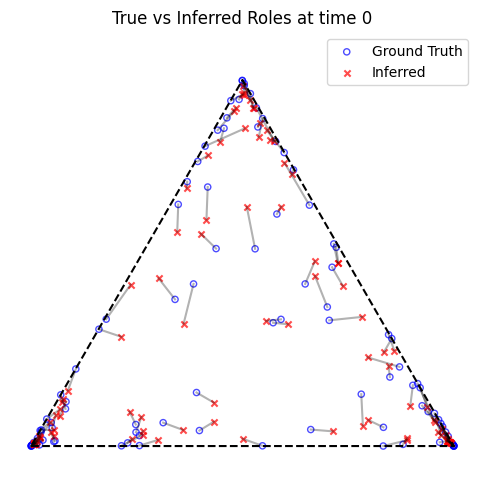

True Mu at time 0: [-0.211 -1.286]
Inferred Mu at time 0: [0.214 0.333]
True Sigma: [[20.  0.]
 [ 0. 20.]]
Inferred Sigma: [[6.783 1.38 ]
 [1.38  8.756]]


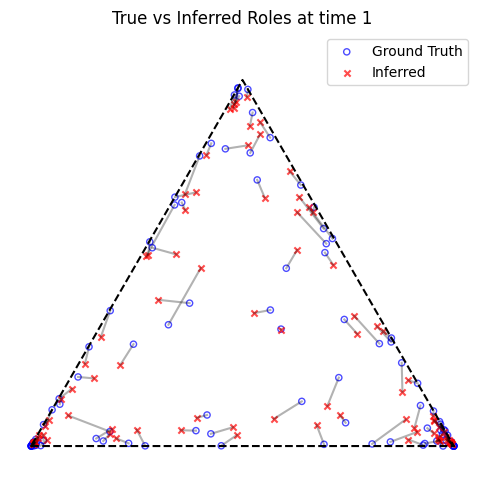

True Mu at time 1: [ 1.372 -0.434]
Inferred Mu at time 1: [0.206 0.304]
True Sigma: [[20.  0.]
 [ 0. 20.]]
Inferred Sigma: [[ 7.612 -0.395]
 [-0.395  7.527]]


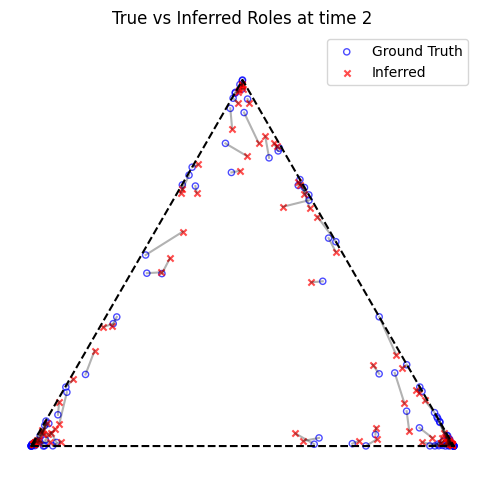

True Mu at time 2: [ 0.977 -1.001]
Inferred Mu at time 2: [0.148 0.253]
True Sigma: [[20.  0.]
 [ 0. 20.]]
Inferred Sigma: [[ 9.524  1.366]
 [ 1.366 11.008]]


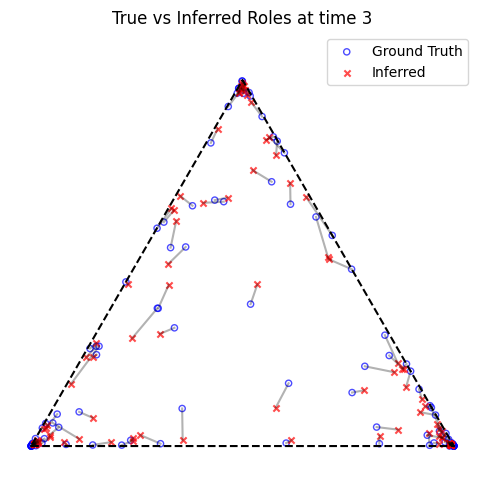

True Mu at time 3: [ 1.258 -0.472]
Inferred Mu at time 3: [0.102 0.173]
True Sigma: [[20.  0.]
 [ 0. 20.]]
Inferred Sigma: [[13.921  7.812]
 [ 7.812 11.332]]
True Phi: [[1.  0.5]
 [0.5 1. ]]
Inferred Phi: [[0.013 0.005]
 [0.005 0.017]]


In [7]:
permutation = [1,2,0] # Manually chosen based on visual inspection
print(inferred_roles.shape)
print(true_roles.shape)

from itertools import permutations

def compute_best_permutation(true_roles, inferred_roles):
    best_perm = None 
    best_loss = jnp.inf
    for perm in permutations(range(true_roles.shape[-1])):
        loss = jnp.mean(jnp.abs(true_roles - inferred_roles[:, perm]))
        if loss < best_loss:
            best_loss = loss
            best_perm = perm
    return best_perm

for t in range(E_sample.shape[0]):
    perm = compute_best_permutation(true_roles[t], inferred_roles[t])
    plot_roles(true_roles[t], inferred_roles[t][:, perm], title=f"True vs Inferred Roles at time {t}")
    print(f"True Mu at time {t}: {gen_model.mu[t]}")
    print(f"Inferred Mu at time {t}: {best_model.mu[t]}")
    print("True Sigma:", gen_model.Sigma[t])
    print("Inferred Sigma:", best_model.Sigma[t])
print("True Phi:", gen_model.Phi)
print("Inferred Phi:", best_model.Phi)

    

In [8]:
best_E = best_model.generate_graph()
print(best_E.shape)

(4, 100, 100)


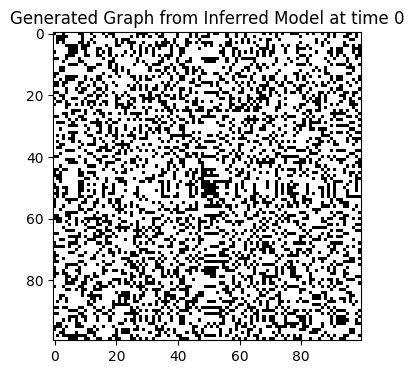

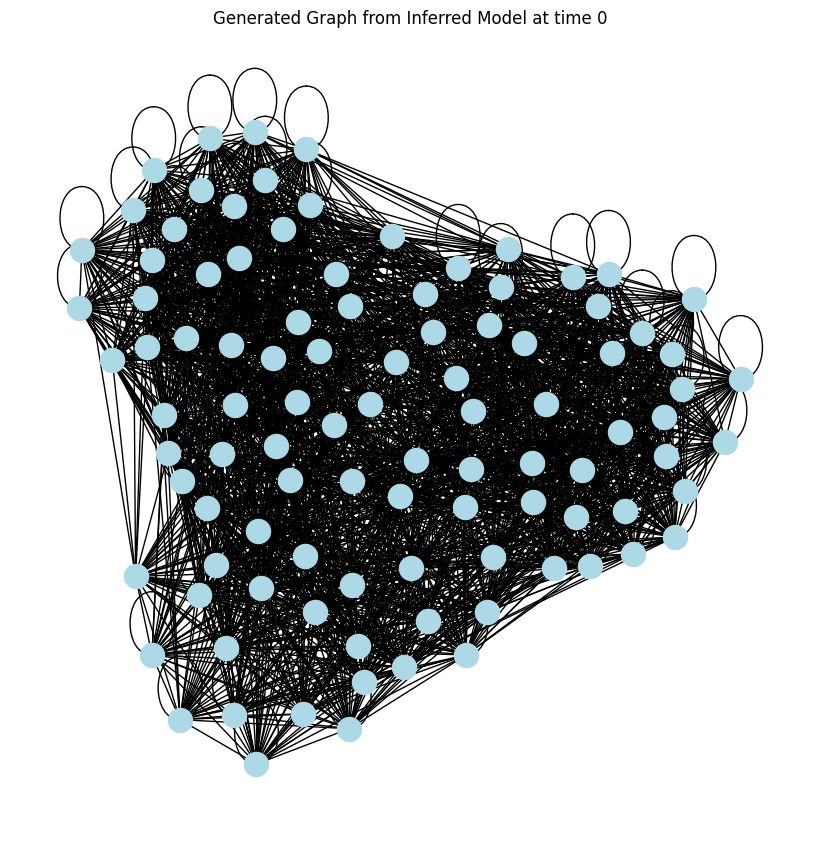

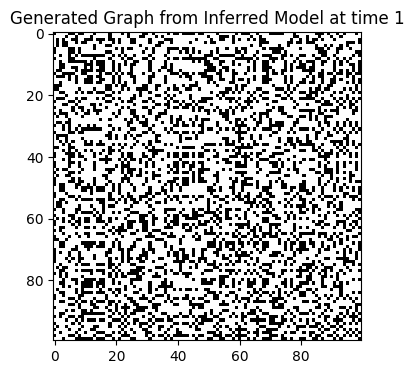

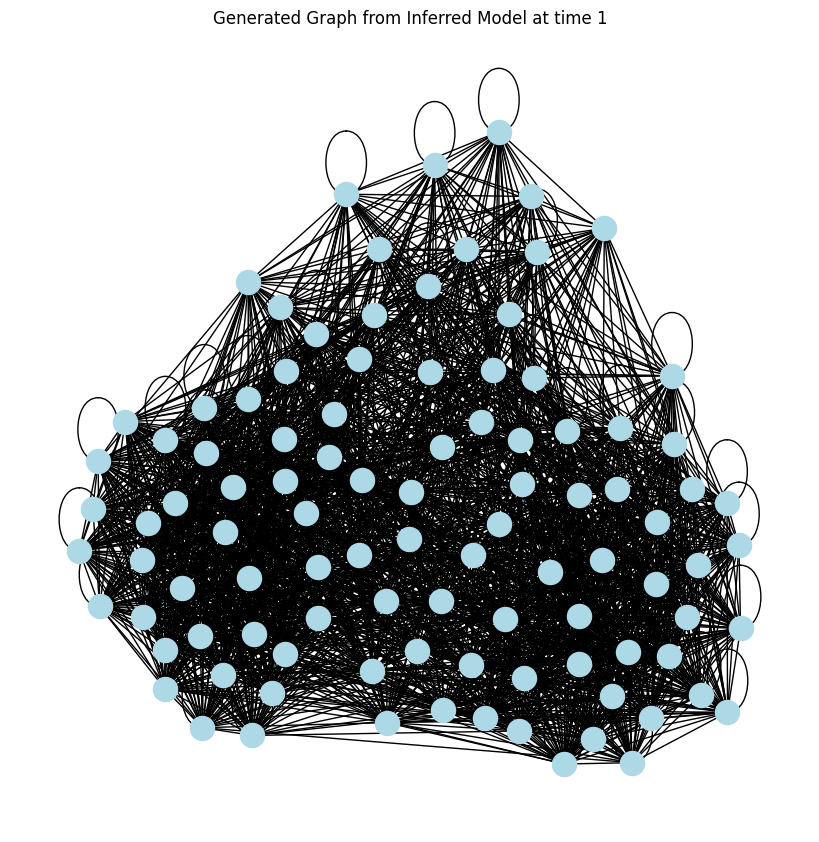

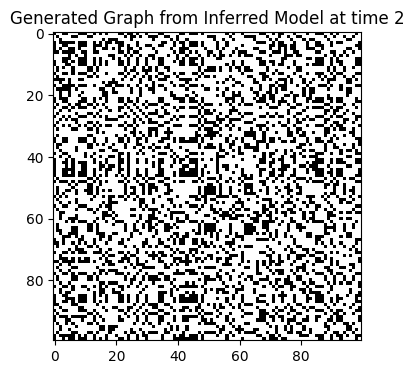

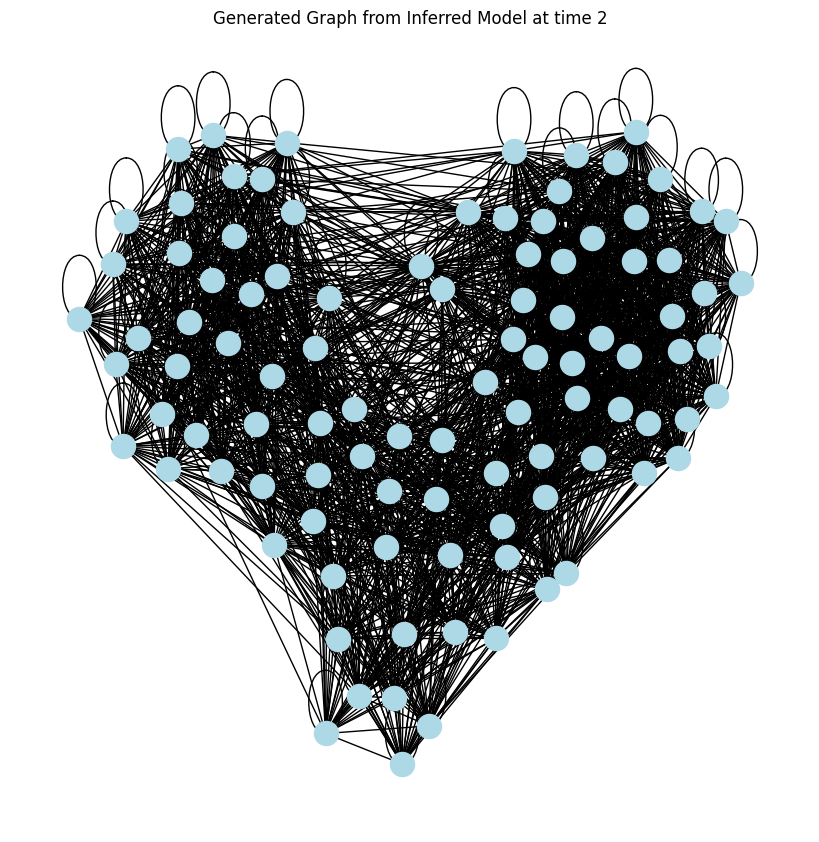

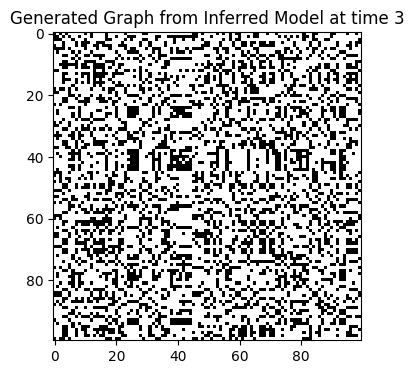

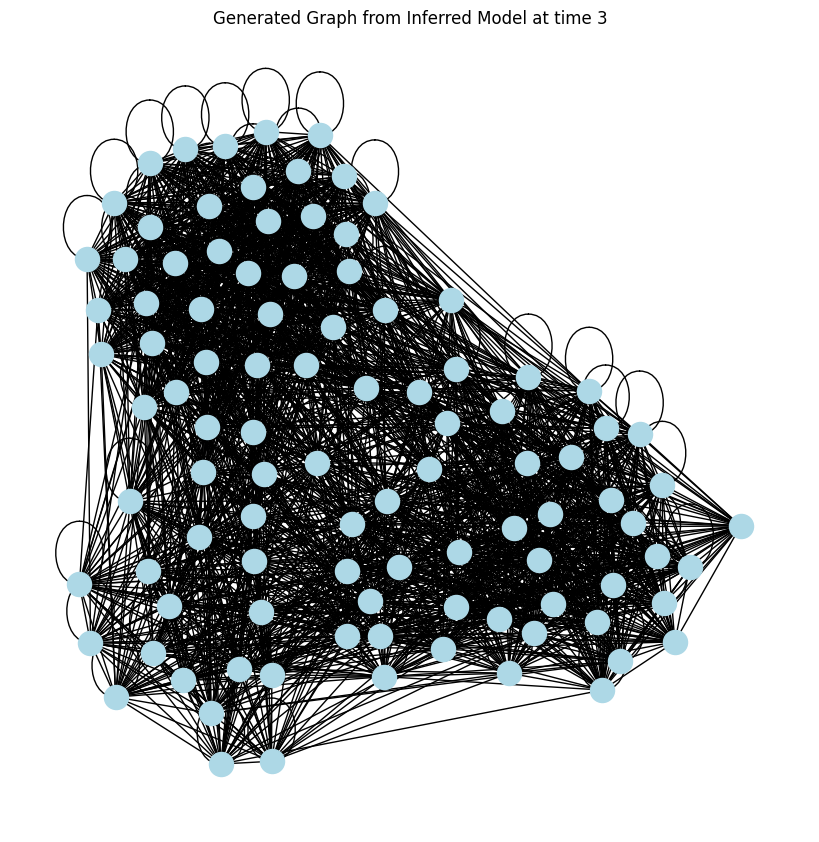

In [9]:
for t in range(best_E.shape[0]):
    plt.figure(figsize=(4, 4))
    plt.imshow(best_E[t], cmap='Greys', vmin=0, vmax=1)
    plt.title(f"Generated Graph from Inferred Model at time {t}")
    plt.show()

    G = nx.from_numpy_array(best_E[t])
    pos = nx.spring_layout(G, k=0.2, iterations=100)
    plt.figure(figsize=(8,8))
    nx.draw(G, pos, node_color='lightblue')
    plt.title(f"Generated Graph from Inferred Model at time {t}")

# Development Tests

In [10]:


def update_mu(mu, P, Y, Sigma, Phi, N):
    '''
    Update mu using Kalman filter and RTS smoother. eq (14 .. 17)
    This version uses the JAX functional update syntax: array.at[...].set(...)
    mu: shape (T,K)
    P: shape (T,K,K)
    Y: shape (T,K)
    Sigma: shape (T,K,K)
    Phi: shape (K,K)
    N: scalar, number of nodes
    '''
    T = mu.shape[0]
    K = Phi.shape[0]

    # --- 1. Kalman Filter (Forward Pass) ---
    # Initialize arrays to store results
    mu_filtered = jnp.zeros_like(mu)
    P_filtered = jnp.zeros_like(P)
    mu_pred = jnp.zeros_like(mu)
    P_pred = jnp.zeros_like(P)

    # Set initial conditions for t=0
    mu_filtered = mu_filtered.at[0].set(mu[0])
    P_filtered = P_filtered.at[0].set(P[0])

    # Loop from t=1 to T-1
    for t in range(1, T):
        # Prediction step
        mu_pred_t = mu_filtered[t-1]
        P_pred_t = P_filtered[t-1] + Phi

        # Store predictions
        mu_pred = mu_pred.at[t].set(mu_pred_t)
        P_pred = P_pred.at[t].set(P_pred_t)

        # Update step
        #K_t = P_pred_t @ jnp.linalg.inv(P_pred_t + Sigma[t]/N)
        tmp = P_pred_t + Sigma[t]/N
        K_t = jnp.linalg.solve(tmp.T, P_pred_t.T).T  # More stable
        mu_t = mu_pred_t + K_t @ (Y[t] - mu_pred_t)
        P_t = P_pred_t - K_t @ P_pred_t

        # Store filtered results
        mu_filtered = mu_filtered.at[t].set(mu_t)
        P_filtered = P_filtered.at[t].set(P_t)

    # --- 2. RTS Smoother (Backward Pass) ---
    # Initialize arrays for smoothed results
    mu_smooth = jnp.zeros_like(mu)
    P_smooth = jnp.zeros_like(P)

    # Set initial conditions for t=T-1
    mu_smooth = mu_smooth.at[-1].set(mu_filtered[-1])
    P_smooth = P_smooth.at[-1].set(P_filtered[-1])

    # Loop from t=T-2 down to 0
    for t in range(T - 2, -1, -1):
        # Smoother gain
        #L_t = P_filtered[t] @ jnp.linalg.inv(P_pred[t+1])
        L_t = jnp.linalg.solve(P_pred[t+1].T, P_filtered[t].T).T  # More stable
        
        # Update step
        mu_smooth_t = mu_filtered[t] + L_t @ (mu_smooth[t+1] - mu_pred[t+1])
        P_smooth_t = P_filtered[t] + L_t @ (P_smooth[t+1] - P_pred[t+1]) @ L_t.T

        # Store smoothed results
        mu_smooth = mu_smooth.at[t].set(mu_smooth_t)
        P_smooth = P_smooth.at[t].set(P_smooth_t)

    return mu_smooth, P_smooth

def update_mu_scan(mu, P, Y, Sigma, Phi, N):
    '''
    Update mu using Kalman filter and RTS smoother with jax.lax.scan.
    mu: shape (T,K) 
    P: shape (T,K,K)
    Y: shape (T,K)
    Sigma: shape (T,K,K) 
    Phi: shape (K,K) 
    N: scalar, number of nodes
    '''
    T = mu.shape[0]

    # --- 1. Kalman Filter (Forward Pass) ---
    def kalman_step(carry, inputs):
        mu_prev, P_prev = carry
        Y_t, Sigma_t = inputs

        # Prediction step
        mu_pred_t = mu_prev
        P_pred_t = P_prev + Phi

        # Update step
        #K_t = P_pred_t @ jnp.linalg.inv(P_pred_t + Sigma_t/N)
        tmp = P_pred_t + Sigma_t/N
        K_t = jnp.linalg.solve(tmp.T, P_pred_t.T).T  #numerically stable version
        mu_t = mu_pred_t + K_t @ (Y_t - mu_pred_t)
        P_t = P_pred_t - K_t @ P_pred_t

        new_carry = (mu_t, P_t)
        # Stack filtered and predicted states for the backward pass
        outputs_to_stack = (mu_t, P_t, mu_pred_t, P_pred_t)
        return new_carry, outputs_to_stack

    init_carry = (mu[0], P[0])
    inputs = (Y[1:], Sigma[1:])
    _, (mu_filtered_scanned, P_filtered_scanned, mu_pred_scanned, P_pred_scanned) = jax.lax.scan(
        kalman_step, init_carry, inputs, unroll=True
    )

    # Combine initial state with scanned results
    mu_filtered = jnp.concatenate([mu[0][None, :], mu_filtered_scanned], axis=0)
    P_filtered = jnp.concatenate([P[0][None, :, :], P_filtered_scanned], axis=0)
    # The prediction for time t is mu_{t-1}, so mu_pred starts from mu_0
    mu_pred = jnp.concatenate([mu[0][None, :], mu_pred_scanned], axis=0)
    P_pred = jnp.concatenate([P[0][None, :, :], P_pred_scanned], axis=0)


    # --- 2. RTS Smoother (Backward Pass) ---
    def rts_smoother_step(carry, inputs):
        mu_smooth_next, P_smooth_next = carry
        mu_filtered_t, P_filtered_t, mu_pred_next, P_pred_next = inputs

        #L_t = P_filtered_t @ jnp.linalg.inv(P_pred_next)
        L_t = jnp.linalg.solve(P_pred_next.T, P_filtered_t.T).T  # numerically stable version
        
        # Update step
        mu_smooth_t = mu_filtered_t + L_t @ (mu_smooth_next - mu_pred_next)
        P_smooth_t = P_filtered_t + L_t @ (P_smooth_next - P_pred_next) @ L_t.T

        new_carry = (mu_smooth_t, P_smooth_t)
        outputs_to_stack = (mu_smooth_t, P_smooth_t)
        return new_carry, outputs_to_stack

    init_carry_smooth = (mu_filtered[-1], P_filtered[-1])
    inputs_smooth = (mu_filtered[:-1], P_filtered[:-1], mu_pred[1:], P_pred[1:])
    
    _, (mu_smooth_scanned, P_smooth_scanned) = jax.lax.scan(
        rts_smoother_step, init_carry_smooth, inputs_smooth, reverse=True, unroll=True
    )

    mu_smooth = jnp.concatenate([mu_smooth_scanned, mu_filtered[-1][None, :]], axis=0)
    P_smooth = jnp.concatenate([P_smooth_scanned, P_filtered[-1][None, :, :]], axis=0)

    return mu_smooth, P_smooth



In [11]:
def test_kalman_smoother_equivalence(seed=0):
    '''
    Tests that the for-loop and jax.lax.scan implementations of the 
    Kalman filter and RTS smoother produce the same results.
    '''
    # 1. Set up test parameters
    key = jax.random.PRNGKey(seed)
    T = 15  # Timesteps
    K = 5   # Roles
    N = 100  # Nodes

    # 2. Generate random valid inputs
    key, subkey = jax.random.split(key)
    mu_init = jax.random.normal(subkey, (T, K))
    
    key, subkey = jax.random.split(key)
    # Ensure P is positive semi-definite
    P_init_rand = jax.random.normal(subkey, (T, K, K))
    P_init = P_init_rand @ jnp.transpose(P_init_rand, (0, 2, 1)) + jnp.eye(K) * 1e-3

    key, subkey = jax.random.split(key)
    Y = jax.random.normal(subkey, (T, K))

    key, subkey = jax.random.split(key)
    # Ensure Sigma is positive semi-definite
    Sigma_rand = jax.random.normal(subkey, (T, K, K))
    Sigma = Sigma_rand @ jnp.transpose(Sigma_rand, (0, 2, 1)) + jnp.eye(K) * 1e-3

    key, subkey = jax.random.split(key)
    # Ensure Phi is positive semi-definite
    Phi_rand = jax.random.normal(subkey, (K, K))
    Phi = Phi_rand @ Phi_rand.T + jnp.eye(K) * 1e-3

    # 3. Run both implementations
    # NOTE: The original loop-based function modifies mu and P in-place,
    # so we must pass copies to ensure a fair comparison.
    mu_loop, P_loop = update_mu(mu_init.copy(), P_init.copy(), Y, Sigma, Phi, N)
    mu_scan, P_scan = update_mu_scan(mu_init.copy(), P_init.copy(), Y, Sigma, Phi, N)

    # 4. Compare results
    mu_are_close = jnp.allclose(mu_loop, mu_scan, atol=1e-5)
    P_are_close = jnp.allclose(P_loop, P_scan, atol=1e-5)

    print(f"Test for Kalman/RTS smoother equivalence:")
    print(f"Smoothed mu results are close: {mu_are_close}")
    print(f"Smoothed P results are close: {P_are_close}")

    if not mu_are_close:
        print("Difference in mu:\n", jnp.abs(mu_loop - mu_scan).max())
    if not P_are_close:
        print("Difference in P:\n", jnp.abs(P_loop - P_scan).max())
    

# Run the test
# for i in range(100):

#     test_kalman_smoother_equivalence(100+i)

## Model validation

In [12]:
import matplotlib.pyplot as plt
import networkx as nx
from utils.plots import plot_roles 
N = 100
K = 3
T = 5
key = jax.random.PRNGKey(0)
B = jnp.array([[  .5, 0.5,  0],
               [0.5,   .5,  0],
               [  0,   0,  1]])

#generate gammas
gamma_0 = jax.random.dirichlet(key, jnp.array([.2,.4,.8]), shape=(N,)) # shape (N,K)
gammas = jnp.zeros((T,N,K))
gammas = gammas.at[0].set(gamma_0)
for t in range(1, T):
    key, subkey = jax.random.split(key)
    gamma_t = jax.random.dirichlet
#gammas = jnp.sort(gammas, axis=-1) # sort gammas for better visualization
plot_roles(gammas[0], gammas[-1], title="Node roles at time 0")
print("gammas :", gammas[0])
def generate_array(pis, B, N, K, key):
     z_ij = jax.random.multinomial(key, 1, pis, shape=(N,N,K)) # shape (N,N,K)
     #print("z_ij shape", z_ij.shape)
     z_ji = jax.random.multinomial(key, 1, pis, shape=(N, N, K)) # shape (N,N,K)
     #print("z_ji shape", z_ji.shape)
     
     p = jnp.einsum('ijk, kl -> ijl', z_ij, B) # shape (N,N,K)
     #print("p first einsum", p.shape)
     p = jnp.einsum('ijl, jil -> ij', p, z_ji) # shape (N,N)
     #print("p second einsum", p.shape)

     E_sampled = jax.random.bernoulli(key, p) # shape (N,N)
     return E_sampled

E = vmap(generate_array, in_axes=(0,None,None,None,0))(gammas, B, N, K, jax.random.split(key, T)) # shape (T,N,N)

for t in range(T):
    plt.imshow(E[t])
    plt.title(f"Adjacency matrix at time {t}")
    plt.colorbar()
    plt.show()
    graph = nx.from_numpy_array(E[t])
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos)
    plt.show()
    





AssertionError: Inferred vectors should sum to 1 across roles.

In [ ]:
T = 5
key = jax.random.PRNGKey(10)
mu_0 = jnp.array([[10, 10]])
mu = jnp.zeros((T,2))
mu = mu.at[0].set(mu_0[0])
var = jnp.array([[1,0.5],
                 [0.5,1]])
for t in range(1, T):
    mu_t = jax.random.multivariate_normal(key, mu[t-1], var)
    mu = mu.at[t].set(mu_t)
    print("Mu at time", t, ":", mu_t)   
print("mu:", mu)



Mu at time 1 : [8.242 8.825]
Mu at time 2 : [6.484 7.649]
Mu at time 3 : [4.726 6.474]
Mu at time 4 : [2.968 5.299]
mu: [[10.    10.   ]
 [ 8.242  8.825]
 [ 6.484  7.649]
 [ 4.726  6.474]
 [ 2.968  5.299]]


In [ ]:
import jax
import jax.numpy as jnp

EPS = 1e-6

# your original loop version
def update_Phi_loop(mu, P, L, K, T):
    sum_val = jnp.zeros((K - 1, K - 1))
    for t in range(0, T - 1):
        diff = mu[t+1] - mu[t]
        term1 = jnp.outer(diff, diff)
        term2 = L[t] @ P[t+1] @ L[t].T
        sum_val += term1 + term2

    Phi_new = sum_val / (T - 1)
    Phi_new = Phi_new + jnp.eye(K - 1) * EPS
    return Phi_new

# my vectorized einsum version
def update_Phi_vec(mu, P, L, K, T):
    diffs = mu[1:] - mu[:-1]  # (T-1, K-1)
    term1 = jnp.einsum("ti,tj->tij", diffs, diffs)
    term2 = jnp.einsum("tik,tkl,tjl->tij", L[:-1], P[1:], L[:-1])
    Phi_new = (term1 + term2).mean(axis=0)
    Phi_new = Phi_new + jnp.eye(K - 1) * EPS
    return Phi_new

# test harness
def test_equivalence(key, T=6, K=4):
    k1, k2, k3 = jax.random.split(key, 3)
    mu = jax.random.normal(k1, (T, K-1))
    P  = jax.random.normal(k2, (T, K-1, K-1))
    L  = jax.random.normal(k3, (T, K-1, K-1))

    out_loop = update_Phi_loop(mu, P, L, K, T)
    out_vec  = update_Phi_vec(mu, P, L, K, T)

    # numerical closeness check
    diff_norm = jnp.linalg.norm(out_loop - out_vec)
    return diff_norm

# run multiple trials
key = jax.random.PRNGKey(0)
for i in range(5):
    d = test_equivalence(jax.random.fold_in(key, i))
    print(f"Trial {i}: ||difference|| = {d:.3e}")

Trial 0: ||difference|| = 2.666e-07
Trial 1: ||difference|| = 1.686e-07
Trial 2: ||difference|| = 0.000e+00
Trial 3: ||difference|| = 1.192e-07
Trial 4: ||difference|| = 4.805e-07
